In [1]:
import numpy as np
import pandas as pd
import pygmo
import sys
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
 
%matplotlib inline

In [2]:
n_prod = 5
n_customer = 1000000

In [3]:
n_customer_predictors=2
n_product_predictors=1

customer_predictors = ['x_c%d'%i for i in range(n_customer_predictors)]
product_predictors = ['x_p%d'%i for i in range(n_product_predictors)]




In [4]:
np.random.seed(123456)
df_prod = pd.DataFrame(np.random.rand(n_prod, n_product_predictors), columns = product_predictors)
df_prod.loc[:, 'RRP'] = ((np.random.rand(n_prod)+.2)*2e3).round(-2)
df_prod.loc[:, 'Service'] = (np.random.rand(n_prod) * 0.7 * df_prod['RRP']).round(-1)
df_prod.loc[:, 'Cost'] = -((np.random.rand(n_prod) * 0.5 + 0.2)* df_prod['RRP']).round(-1)

df_prod

,x_p0,RRP,Service,Cost
0,0.126970,1100.0,290.0,-410.0
1,0.966718,1300.0,410.0,-410.0
2,0.260476,2100.0,190.0,-1240.0
3,0.897237,600.0,360.0,-300.0
4,0.376750,1500.0,860.0,-400.0


In [5]:
min_Price = df_prod['RRP'].min()*0.9
max_Price = df_prod['RRP'].max()*1.1

# df_customer = pd.DataFrame(np.random.rand(n_customer, n_customer_predictors), columns = customer_predictors)
# df_customer = pd.DataFrame(np.ones((n_customer, n_customer_predictors)), columns = customer_predictors)
df_customer = pd.DataFrame(np.clip(np.random.randn(n_customer, n_customer_predictors)*0.1+0.5, 0., 1.), columns = customer_predictors)

df_customer.loc[:, 'nPurchases']= (24*(np.random.rand(n_customer)**3)).round()
df_customer.loc[:, 'AvgPrice']= (min_Price + (max_Price-min_Price)*np.random.rand(n_customer)).round(-1)
df_customer.loc[:, 'AvgService']= (np.random.rand(n_customer) * 0.7 * df_customer['AvgPrice']).round(-1)
df_customer.loc[:, 'nPurchasesDiscount']= (np.random.rand(n_customer)*df_customer['nPurchases']).round()
df_customer.loc[:, 'AvgDiscount']= ((np.random.randn(n_customer)*0.2+1)*0.1*df_customer['AvgPrice']).round()
df_customer.loc[:, 'CLV']=((np.random.randn(n_customer)*0.1+1)* df_customer.eval('sqrt(nPurchases+10)*(AvgPrice+AvgService)')).round(-2)

print(df_customer.shape)
df_customer.describe()


(1000000, 8)


,x_c0,x_c1,nPurchases,AvgPrice,AvgService,nPurchasesDiscount,AvgDiscount,CLV
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.00000
mean,0.499988,0.500139,5.975454,1424.079410,498.275670,2.986722,142.330868,7528.36130
std,0.099998,0.099924,6.823806,510.781618,354.571117,4.313762,59.325915,3486.59158
min,0.000000,0.039714,0.000000,540.000000,0.000000,0.000000,10.000000,1300.00000
25%,0.432566,0.432838,0.000000,980.000000,210.000000,0.000000,94.000000,4800.00000
50%,0.500019,0.500092,3.000000,1420.000000,430.000000,1.000000,137.000000,7000.00000
75%,0.567369,0.567460,10.000000,1870.000000,720.000000,4.000000,184.000000,9600.00000
max,0.978614,0.986989,24.000000,2310.000000,1620.000000,24.000000,421.000000,27400.00000


In [6]:
df_prod.loc[:, 'product_id']=df_prod.index
df_customer.loc[:, 'customer_id']=df_customer.index
df_customer.loc[:, 'product_id']= np.random.randint(0, len(df_prod), len(df_customer))

df = pd.merge(df_customer, df_prod, on='product_id').sort_values('customer_id')

df.loc[:, 'Discount'] = (df['RRP']*np.random.rand(len(df))*0.2).round(-1)

In [7]:
df_customer.shape, df_prod.shape, df.shape

((1000000, 10), (5, 5), (1000000, 15))

In [8]:
df.head(10)

,x_c0,x_c1,nPurchases,AvgPrice,AvgService,nPurchasesDiscount,AvgDiscount,CLV,customer_id,product_id,x_p0,RRP,Service,Cost,Discount
0,0.457503,0.556702,0.0,1370.0,690.0,0.0,93.0,5600.0,0,1,0.966718,1300.0,410.0,-410.0,30.0
199235,0.527623,0.391260,5.0,580.0,310.0,4.0,61.0,3900.0,1,4,0.376750,1500.0,860.0,-400.0,250.0
1,0.432631,0.511365,2.0,1730.0,1180.0,2.0,104.0,10100.0,2,1,0.966718,1300.0,410.0,-410.0,180.0
399221,0.352157,0.552499,3.0,1570.0,190.0,2.0,156.0,5600.0,3,0,0.126970,1100.0,290.0,-410.0,130.0
199236,0.540471,0.557705,2.0,2220.0,720.0,1.0,238.0,9800.0,4,4,0.376750,1500.0,860.0,-400.0,260.0
2,0.328500,0.396073,1.0,1190.0,260.0,0.0,121.0,5100.0,5,1,0.966718,1300.0,410.0,-410.0,40.0
599558,0.462935,0.384211,0.0,1870.0,450.0,0.0,162.0,6700.0,6,2,0.260476,2100.0,190.0,-1240.0,390.0
599559,0.365569,0.584489,9.0,570.0,270.0,5.0,79.0,3900.0,7,2,0.260476,2100.0,190.0,-1240.0,70.0
399222,0.607577,0.489095,0.0,1230.0,150.0,0.0,137.0,4300.0,8,0,0.126970,1100.0,290.0,-410.0,180.0
3,0.664356,0.353061,1.0,1880.0,840.0,1.0,136.0,8900.0,9,1,0.966718,1300.0,410.0,-410.0,180.0


In [9]:
df.loc[:, 'BaseProb'] =  df.eval('x_c0*exp(-(((AvgPrice-RRP)/0.5/AvgPrice)**2))')  # x_c0: customer base scale

df.loc[:, 'D_Scale_exp'] = df.eval('AvgDiscount/(AvgPrice + x_c1 * AvgService )') # x_c2: customer weight of service price
df.loc[:, 'D_Scale_act'] = df.eval('Discount/(RRP + x_c1 * Service )')
df.loc[:, 'D_Freq'] = df.eval('(nPurchasesDiscount+0.3)/(nPurchases+1)')

df.loc[:, 'DiscountNudge'] = df.eval('D_Freq*(1+tanh((D_Scale_act-D_Scale_exp)*50))')

df.loc[:, 'Probability'] = df.eval('tanh(BaseProb * (1 + DiscountNudge))')

df.loc[:, 'is_deal'] = (np.random.rand(len(df)) < df['Probability']).astype(int) 

In [10]:
col_models = ['Probability' ,'BaseProb','DiscountNudge', ]

col_grby = ['product_id','Discount']
# col_grby = [(df['D_Scale_exp']*4).round(1)/4.,(df['D_Scale_act']*4).round(1)/4.]

In [11]:
df[col_models].describe(np.arange(0, 1., 0.2))

,Probability,BaseProb,DiscountNudge
count,1000000.000000,1000000.000000,1.000000e+06
mean,0.336536,0.271545,4.093677e-01
std,0.230922,0.183369,4.743266e-01
min,0.000000,0.000000,1.316636e-08
0%,0.000000,0.000000,1.316636e-08
20%,0.093887,0.073823,3.654592e-03
40%,0.262215,0.212025,8.299971e-02
50%,0.336006,0.275617,2.244505e-01
60.0%,0.401651,0.333832,4.181494e-01
80%,0.540654,0.446826,7.470005e-01


In [12]:
df.groupby(col_grby)[col_models].mean()

Probability  BaseProb  DiscountNudge
product_id Discount                                      
0          0.0          0.294312  0.309524       0.000726
           10.0         0.291739  0.306410       0.001762
           20.0         0.291432  0.305559       0.003659
           30.0         0.294386  0.307649       0.007943
           40.0         0.295170  0.306179       0.016485
           50.0         0.298760  0.306265       0.030337
           60.0         0.306194  0.305978       0.060704
           70.0         0.315062  0.304526       0.102891
           80.0         0.329749  0.305552       0.162471
           90.0         0.352181  0.307762       0.246962
           100.0        0.379052  0.312139       0.346612
           110.0        0.398388  0.307430       0.453374
           120.0        0.418546  0.307165       0.553415
           130.0        0.438798  0.307234       0.647183
           140.0        0.452685  0.306887       0.719258
           150.0        0.460418  0.306698       0.755488
           160.0        0.470452  0.311167       0.783705
           170.0        0.469533  0.306221       0.805830
           180.0        0.471987  0.307902       0.814372
           190.0        0.472916  0.306692       0.822980
           200.0        0.477233  0.309724       0.824942
           210.0        0.477388  0.308823       0.828053
           220.0        0.473946  0.305752       0.833052
1          0.0          0.298537  0.315606       0.000800
           10.0         0.300914  0.318124       0.001437
           20.0         0.300063  0.316702       0.002856
           30.0         0.299487  0.315252       0.005658
           40.0         0.304895  0.319902       0.010501
           50.0         0.305879  0.318930       0.017196
           60.0         0.309202  0.318729       0.030691
           70.0         0.311819  0.316041       0.051455
           80.0         0.324063  0.320635       0.084729
           90.0         0.327824  0.313716       0.127989
           100.0        0.344301  0.316023       0.188519
           110.0        0.363463  0.317440       0.265542
           120.0        0.381226  0.317721       0.340814
           130.0        0.400297  0.317665       0.427273
           140.0        0.415199  0.314625       0.513551
           150.0        0.435143  0.318738       0.586797
           160.0        0.445764  0.316042       0.654715
           170.0        0.458795  0.315662       0.721428
           180.0        0.466082  0.315377       0.760318
           190.0        0.471677  0.317743       0.776882
           200.0        0.472704  0.315685       0.796937
           210.0        0.482008  0.319493       0.813721
           220.0        0.481892  0.318558       0.822711
           230.0        0.483671  0.319676       0.821954
           240.0        0.477489  0.317625       0.810734
           250.0        0.480001  0.317369       0.821406
           260.0        0.481077  0.316133       0.830425
2          0.0          0.217110  0.231728       0.000716
           10.0         0.212525  0.226684       0.001145
           20.0         0.218574  0.232839       0.002066
           30.0         0.216880  0.230946       0.003076
           40.0         0.215580  0.229362       0.004416
           50.0         0.218561  0.232013       0.007113
           60.0         0.218840  0.231183       0.010791
           70.0         0.213703  0.224940       0.016711
           80.0         0.223518  0.233667       0.024022
           90.0         0.224699  0.233620       0.034893
           100.0        0.229444  0.235570       0.048363
           110.0        0.231413  0.233306       0.070198
           120.0        0.233500  0.230916       0.095720
           130.0        0.241513  0.234478       0.122206
           140.0        0.243206  0.229120       0.161196
           150.0        0.251077  0.229516       0.210177
           160.0        0.260882  0.232438       0.249338
           170.0   

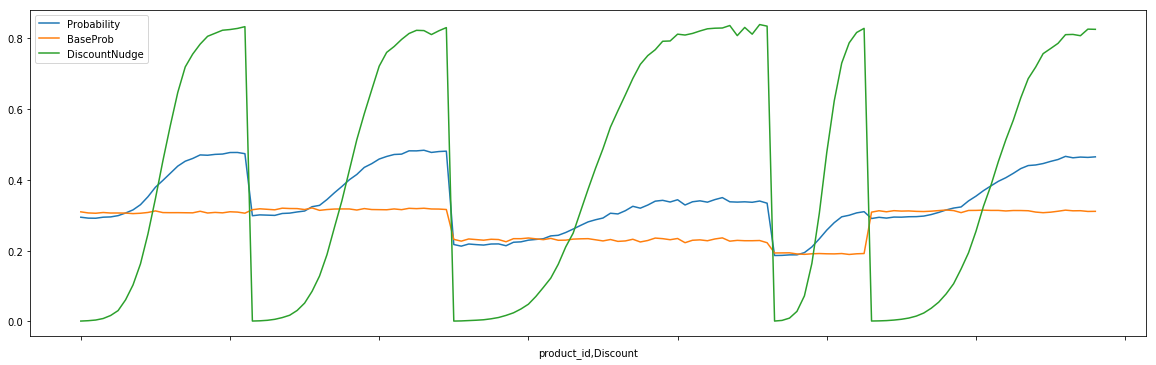

In [13]:
ax = df.groupby(col_grby)[col_models].mean().plot(legend=True, figsize=(20,6))

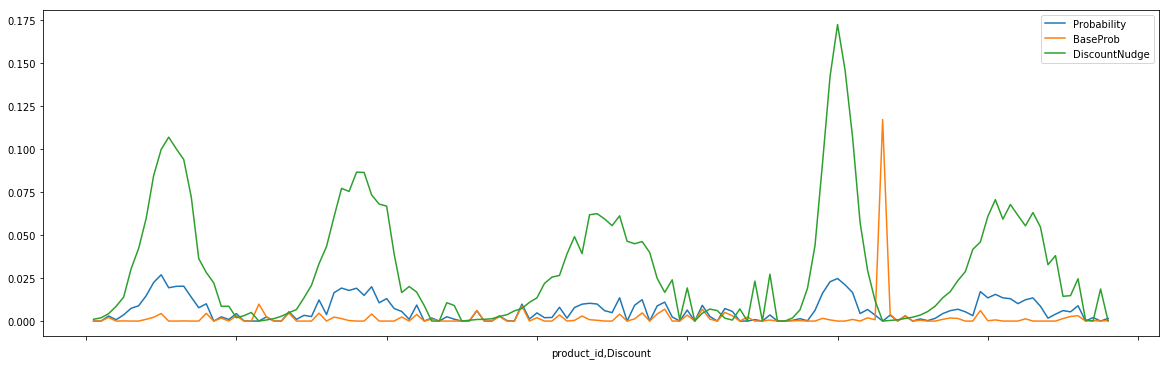

In [14]:
ax = df.groupby(col_grby)[col_models].mean().diff().clip(0).plot(legend=True, figsize=(20,6))


In [15]:
df.to_csv('training_data_randn.csv', index=False)